In [60]:
import numpy as np
import numpy.typing as npt
#import sympy as sp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#Simulation variables:
start_time = 0
stop_time = 10
time_step = 0.01

#DEFINING CONSTANTS:
L_1 = 10
L_2 = 26
L_3  = 18
G = 20
omega = 1.5 #rad/s

#Points of joints
s_1_p1 = np.array([[-L_1/2], [0]])
s_1_p2 = np.array([[L_1/2], [0]])
s_2_p2 = np.array([[-L_2/2], [0]])
s_2_p3 = np.array([[L_2/2], [0]])
s_3_p3 = np.array([[-L_3/2], [0]])
s_3_p4 = np.array([[L_3/2], [0]])
#Combined the point vectors into a matrix
combined_s_p_vec = np.hstack([s_1_p1, s_1_p2, s_2_p2, s_2_p3, s_3_p3, s_3_p4])

#Constraint distances
c_1 = np.zeros((2,1))
c_2 = c_1
c_3 = c_2
c_4 = np.array([[20], [0]])
#Combined the constraint vectors into matrices by hstack
combined_c_vec = np.hstack([c_1, c_2, c_3, c_4])

""" # r-vectors
r_1 = np.array([[x_1], [y_1]])
r_2 = np.array([[x_2], [y_2]])
r_3 = np.array([[x_3], [y_3]])
 """
""" test_vector = np.array([[0, 5, np.pi/2, 0, 0, 0, 20, 9, np.pi/2]]).reshape(9,1)
#TEST CASE _|
test_r_vec = np.array([[1, 2], [0, 1]])
test_phi_vec = np.array([[0], [np.pi/2]])
test_s_p_vec = np.array([[1, -1], [0, 0]])
test_c_vec = np.array([[2], [0]])
#test = phi_rel(test_r_vec, test_phi_vec, test_s_p_vec, test_c_vec)
test = phi_abs(test_r_vec[:,0], test_phi_vec[0], test_s_p_vec[:,0], test_c_vec)
test = phi_equations_system(test_vector, 0)
#print(f"test: {test}") """

nu = np.array([[0, 0, 0, 0, 0, 0, 0, 0, omega]]).T

#A-matrix
def A_matrix(phi):
    A_matrix = np.squeeze(np.array([[np.cos(phi), -np.sin(phi)], [np.sin(phi), np.cos(phi)]]))
    return A_matrix

def B_matrix(phi):
    B_matrix = np.squeeze(np.array([[-np.sin(phi), -np.cos(phi)], [np.cos(phi), -np.sin(phi)]]))
    return B_matrix


def global_transformation_2D(translation_vector: npt.ArrayLike, rotational_angle, local_point: npt.ArrayLike) -> np.ndarray:
    orientation_matrix = A_matrix(rotational_angle)
    local_point = np.atleast_1d(local_point)
    
    global_vector = translation_vector + orientation_matrix @ local_point
    
    return global_vector

#Phi equations
def phi_rel(r_mat, phi_vec, s_p_mat, c_vec):
    r_vec_1 = r_mat[:,0].reshape(2,1)
    r_vec_2 = r_mat[:,1].reshape(2,1)
    s_p_mat_1 = s_p_mat[:,0].reshape(2,1)
    s_p_mat_2 = s_p_mat[:,1].reshape(2,1)
    c_vec = c_vec.reshape(2,1)
    relative_constraint_result = (r_vec_1 + A_matrix(phi_vec[0]) @ s_p_mat_1) - (r_vec_2 + A_matrix(phi_vec[1]) @ s_p_mat_2) - c_vec
    return relative_constraint_result

def phi_abs(r_vec, phi_elem, s_p_vec, c_vec):
    r_vec_1 = r_vec.reshape(2,1)
    s_p_vec_1 = s_p_vec.reshape(2,1)
    c_vec = c_vec.reshape(2,1)
    absolute_constraint_result = (r_vec_1 + A_matrix(phi_elem[0]) @ s_p_vec_1) - c_vec
    return absolute_constraint_result

def phi_driver(phi_val, t, omega=omega):
    driving_constraint = phi_val - omega * t
    return driving_constraint

def phi_equations_system(q, t, verbose=False):
    r_1 = q[0:2].reshape(2,1)
    phi_1 = q[2:3].reshape(1,1)
    r_2 = q[3:5].reshape(2,1)
    phi_2 = q[5:6].reshape(1,1)
    r_3 = q[6:8].reshape(2,1)
    phi_3 = q[8:9].reshape(1,1)

    r_12= np.hstack((r_1, r_2))
    phi_12= np.vstack((phi_1, phi_2))
    r_23= np.hstack((r_2, r_3))
    phi_23= np.vstack((phi_2, phi_3))
    
    phi_abs_1 = phi_abs(r_vec=r_1, phi_elem=phi_1, s_p_vec=combined_s_p_vec[:,0], c_vec=combined_c_vec[:,0])
    phi_rel_1 = phi_rel(r_mat=r_12, phi_vec=phi_12, s_p_mat=combined_s_p_vec[:,1:3], c_vec=combined_c_vec[:,1])
    phi_rel_2 = phi_rel(r_mat=r_23, phi_vec=phi_23, s_p_mat=combined_s_p_vec[:,3:5], c_vec=combined_c_vec[:,2])
    phi_abs_2 = phi_abs(r_vec=r_3, phi_elem=phi_3, s_p_vec=combined_s_p_vec[:,5], c_vec=combined_c_vec[:,3])
    phi_ad_1 = phi_driver(phi_1, t, omega=omega)

    vector_of_equations = np.vstack((phi_abs_1, phi_rel_1, phi_rel_2, phi_abs_2, phi_ad_1))

    if verbose == True:
        print(f"phi abs 1 {phi_abs_1}")
        print(f"phi rel 1 {phi_rel_1}")
        print(f"phi rel 2 {phi_rel_2}")
        print(f"phi abs 2 {phi_abs_2}")

    return vector_of_equations



def phi_jacobian(q):
    s_p_j = combined_s_p_vec
    phi = q[2:9:3]
    I_2x2 = np.eye(2,2)
    zero_2x2 = np.zeros((2,2))
    zero_2x = np.zeros((2,))
    column_12 = np.vstack((I_2x2, I_2x2, zero_2x2, zero_2x2))
    column_3 = np.concatenate((B_matrix(phi[0])@s_p_j[:,0], B_matrix(phi[0])@s_p_j[:,1], zero_2x, zero_2x)).reshape(8,1)
    column_45 = np.vstack((zero_2x2, -I_2x2, I_2x2, zero_2x2))
    column_6 = np.concatenate((zero_2x, -B_matrix(phi[1])@s_p_j[:,2], B_matrix(phi[1])@s_p_j[:,3], zero_2x)).reshape(8,1)
    column_78 = np.vstack((zero_2x2, zero_2x2, -I_2x2, I_2x2,))
    column_9 = np.concatenate((zero_2x, zero_2x, -B_matrix(phi[2])@s_p_j[:,4], B_matrix(phi[2])@s_p_j[:,5])).reshape(8,1)
    column_hstack = np.hstack((column_12, column_3, column_45, column_6, column_78, column_9))
    driver_row = np.array([[0, 0, 1, 0, 0, 0, 0, 0, 0]])
    jacobian_matrix = np.vstack((column_hstack, driver_row))

    #print(jacobian_matrix)
    return jacobian_matrix

def newton_rhapson(function=phi_equations_system, initial_guess = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0]]), jacobian=phi_jacobian, t=0, rtol=1e-3, max_iter=500, verbose=False):
    old_val = initial_guess.reshape(-1,1)
    iter = 0
    norm = 1
    for iter in range(max_iter):

        if rtol < norm:
            
            function_value = function(old_val, t)
            jacobian_value_inv = np.linalg.inv(jacobian(old_val))

            current_val = old_val - jacobian_value_inv @ function_value
            norm = np.linalg.norm(old_val - current_val)
            old_val = current_val
        else:
            break

        iter+= 1

    if verbose == True:
        print(f"The Newton Rhapson finished in {iter} iterations with a tolerance of {norm}")
    return current_val

def get_velocity_matrix(position_matrix, jacobian, nu=nu):
    nu = nu.reshape(-1)
    position_length = position_matrix.shape[1]
    velocity_matrix = np.empty((position_matrix.shape[0], position_length))
    for position in range(position_length):
        velocity_matrix[:, position] = np.linalg.inv(jacobian(position_matrix[:,position])) @ nu
    return velocity_matrix

def solve_systems(function, initial_guess, jacobian, t_start, t_stop, t_step, max_iter=50, rtol=1e-3, verbose=False):
    current_position = initial_guess.reshape(-1,1)
    time_vector = np.arange(t_start, t_stop, t_step)
    position_matrix = np.empty((len(current_position), len(time_vector)))
    for time_index, time_value in enumerate(time_vector):
        current_position = newton_rhapson(function, current_position, jacobian, time_value, max_iter=max_iter, verbose=verbose)
        position_matrix[:, time_index] = current_position.squeeze()

    velocity_matrix = get_velocity_matrix(position_matrix, jacobian, nu=nu)
    
    return position_matrix, velocity_matrix, time_vector

IG = np.array([[5, 0, 0, 20, 10, np.pi/4, 20, 9, np.pi+np.pi/2]])
#test_example = newton_rhapson(phi_equations_system, IG, phi_jacobian, 1, max_iter=50)
test_example, test_velocity, test_time_vector = solve_systems(phi_equations_system, IG, phi_jacobian, start_time, stop_time, time_step)

with np.printoptions(precision=3, threshold=10000, linewidth=np.inf, suppress=True):
    print(test_example.T)


[[ 5.     0.     0.    21.3    6.427  0.517 26.3    6.427  3.937]
 [ 4.999  0.075  0.015 21.393  6.41   0.502 26.393  6.335  3.922]
 [ 4.998  0.15   0.03  21.478  6.396  0.488 26.48   6.246  3.909]
 [ 4.995  0.225  0.045 21.555  6.386  0.474 26.56   6.161  3.896]
 [ 4.991  0.3    0.06  21.626  6.381  0.461 26.635  6.081  3.883]
 [ 4.986  0.375  0.075 21.689  6.38   0.448 26.703  6.006  3.872]
 [ 4.98   0.449  0.09  21.745  6.385  0.436 26.766  5.935  3.862]
 [ 4.972  0.524  0.105 21.795  6.394  0.424 26.823  5.87   3.852]
 [ 4.964  0.599  0.12  21.838  6.408  0.412 26.874  5.809  3.843]
 [ 4.955  0.673  0.135 21.875  6.427  0.402 26.92   5.754  3.835]
 [ 4.944  0.747  0.15  21.906  6.451  0.391 26.962  5.704  3.828]
 [ 4.932  0.821  0.165 21.931  6.48   0.381 26.999  5.659  3.822]
 [ 4.919  0.895  0.18  21.95   6.514  0.372 27.031  5.619  3.816]
 [ 4.905  0.969  0.195 21.964  6.552  0.363 27.059  5.584  3.811]
 [ 4.89   1.042  0.21  21.973  6.596  0.354 27.082  5.553  3.807]
 [ 4.874  

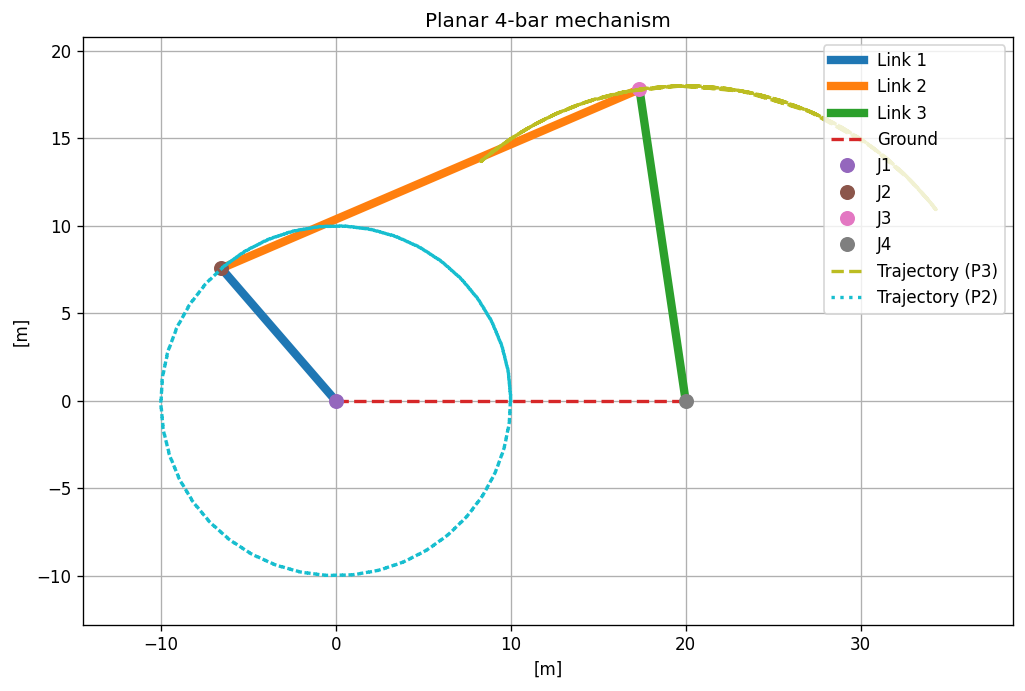

In [ ]:


# ---------------------- PLOTTING THE MECHANISM ----------------------
# test_example has shape (9, T):
# [x1, y1, phi1, x2, y2, phi2, x3, y3, phi3] by rows, time by columns
# test_time_vector has length T, time_step is your dt

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

T = test_example.shape[1]
dt = time_step

frame_step = 10  # 1=every frame, 10=every 10th, 100=every 100th, ...
frames_idx = np.arange(0, T, frame_step)

fps = int(round(1.0 / (dt * frame_step)))
interval_ms = int(round(1000 * dt * frame_step))

# Convenience slices
r1 = test_example[0:2, :].T  # (T, 2)
p1 = test_example[2, :]      # (T,)
r2 = test_example[3:5, :].T
p2 = test_example[5, :]
r3 = test_example[6:8, :].T
p3 = test_example[8, :]

# Vectorized transform of a local point s=[sx, sy] on a body (r, phi) -> world
def transform_series(r_xy, phi, s_xy):
    sx, sy = float(s_xy[0]), float(s_xy[1])
    c, s = np.cos(phi), np.sin(phi)
    x = r_xy[:, 0] + c * sx - s * sy
    y = r_xy[:, 1] + s * sx + c * sy
    return np.column_stack([x, y])  # (T, 2)

# Joint global positions over time:
P1 = transform_series(r1, p1, s_1_p1.squeeze())  # body 1, left end
P2 = transform_series(r1, p1, s_1_p2.squeeze())  # body 1, right end  == body 2 left
# (equivalently) could use transform_series(r2, p2, s_2_p2)
P3 = transform_series(r2, p2, s_2_p3.squeeze())  # body 2, right end  == body 3 left
P4 = transform_series(r3, p3, s_3_p4.squeeze())  # body 3, right end (ground)

# (Sanity: in a well-solved configuration, P1 ~ c1, P4 ~ c4)
# print(np.linalg.norm(P1 - combined_c_vec[:,0].ravel(), axis=1).max())
# print(np.linalg.norm(P4 - combined_c_vec[:,3].ravel(), axis=1).max())

# Axis limits (pad around all joint paths)
all_x = np.hstack([P1[:,0], P2[:,0], P3[:,0], P4[:,0]])
all_y = np.hstack([P1[:,1], P2[:,1], P3[:,1], P4[:,1]])
xmin, xmax = all_x.min(), all_x.max()
ymin, ymax = all_y.min(), all_y.max()
padx = 0.1 * max(1e-9, xmax - xmin)
pady = 0.1 * max(1e-9, ymax - ymin)

fig, ax = plt.subplots(figsize=(10, 8), dpi=120)
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(xmin - padx, xmax + padx)
ax.set_ylim(ymin - pady, ymax + pady)
ax.grid(True)
ax.set_xlabel('[m]')
ax.set_ylabel('[m]')
ax.set_title('Planar 4-bar mechanism')

# Link segments (current configuration)
(link1_line,) = ax.plot([], [], '-',  linewidth=5, animated=True, label='Link 1')
(link2_line,) = ax.plot([], [], '-',  linewidth=5, animated=True, label='Link 2')
(link3_line,) = ax.plot([], [], '-',  linewidth=5, animated=True, label='Link 3')
(ground_line,) = ax.plot([], [], '--', linewidth=2, animated=True, label='Ground')

# Joint markers
(j1_marker,) = ax.plot([], [], 'o', markersize=8, animated=True, label='J1')
(j2_marker,) = ax.plot([], [], 'o', markersize=8, animated=True, label='J2')
(j3_marker,) = ax.plot([], [], 'o', markersize=8, animated=True, label='J3')
(j4_marker,) = ax.plot([], [], 'o', markersize=8, animated=True, label='J4')

# A trajectory trace (e.g., of the coupler point P3)
(traj_p3_line,) = ax.plot([], [], '--', linewidth=2, animated=True, label='Trajectory (P3)')
(traj_p2_line,) = ax.plot([], [], ':', linewidth=2, animated=True, label='Trajectory (P2)')


ax.legend(loc='upper right')

def frame_update(i):
    idx = frames_idx[i]
    p1 = P1[idx]; p2 = P2[idx]; p3 = P3[idx]; p4 = P4[idx]

    link1_line.set_data([p1[0], p2[0]], [p1[1], p2[1]])
    link2_line.set_data([p2[0], p3[0]], [p2[1], p3[1]])
    link3_line.set_data([p3[0], p4[0]], [p3[1], p4[1]])
    ground_line.set_data([P1[0,0], P4[0,0]], [P1[0,1], P4[0,1]])

    j1_marker.set_data([p1[0]], [p1[1]])
    j2_marker.set_data([p2[0]], [p2[1]])
    j3_marker.set_data([p3[0]], [p3[1]])
    j4_marker.set_data([p4[0]], [p4[1]])

    # trace only the shown (subsampled) frames
    traj_p3_line.set_data(P3[frames_idx[:i+1], 0], P3[frames_idx[:i+1], 1])
    traj_p2_line.set_data(P2[frames_idx[:i+1], 0], P2[frames_idx[:i+1], 1])

    return (link1_line, link2_line, link3_line, ground_line,
            j1_marker, j2_marker, j3_marker, j4_marker,
            traj_p3_line, traj_p2_line)



# Recreate the animation (interval is in ms)
anim = FuncAnimation(
    fig,
    frame_update,
    frames=len(frames_idx),
    blit=True,
    interval=interval_ms,
)


# Save a GIF and also embed inline if you're in a notebook
anim.save("saved_animation.gif", fps=fps)
HTML(anim.to_jshtml(fps=fps))


In [54]:

# --- Save the first frame as a PNG ---
first_i = 0   # if you're using subsampling
frame_update(first_i)           # draw final state onto the artists
fig.canvas.draw()              # ensure the canvas is updated
fig.savefig("mechanism_first_frame.png", dpi=300, bbox_inches="tight")
# --- Save the last frame as a PNG ---
last_i = len(frames_idx) - 1   # if you're using subsampling
frame_update(last_i)           # draw final state onto the artists
fig.canvas.draw()              # ensure the canvas is updated
fig.savefig("mechanism_last_frame.png", dpi=300, bbox_inches="tight")



TypeError: 'int' object is not subscriptable

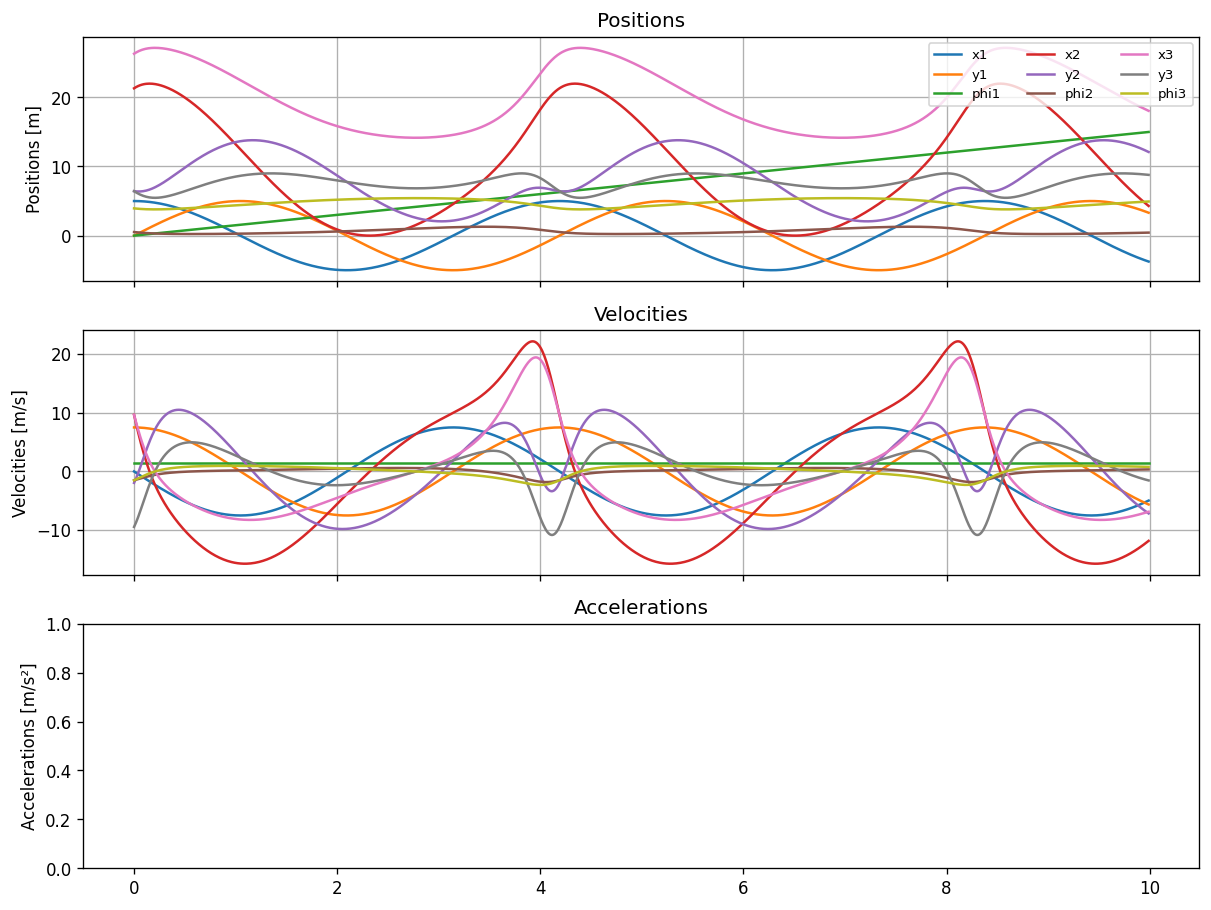

In [67]:
# --- NEW CELL: 3-row subplots for positions / velocities / accelerations ---
position_matrix, velocity_matrix, acceleration_matrix = test_example, test_velocity, 0
# Use the time vector already in your workspace
try:
    t = time_vector
except NameError:
    t = test_time_vector  # fallback if you kept this name

labels = ['x1','y1','phi1','x2','y2','phi2','x3','y3','phi3']

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 9), dpi=120, sharex=True)

# Positions
axes[0].set_title('Positions')
axes[0].set_ylabel('Positions [m]')
for i, name in enumerate(labels):
    axes[0].plot(t, position_matrix[i, :], label=name)
axes[0].grid(True)
axes[0].legend(loc='upper right', ncol=3, fontsize=8)

# Velocities
axes[1].set_title('Velocities')
axes[1].set_ylabel('Velocities [m/s]')
for i in range(9):
    axes[1].plot(t, velocity_matrix[i, :])
axes[1].grid(True)

# Accelerations
axes[2].set_title('Accelerations')
axes[2].set_ylabel('Accelerations [m/s²]')
for i in range(9):
    axes[2].plot(t, acceleration_matrix[i, :])
axes[2].set_xlabel('Time [s]')
axes[2].grid(True)

#fig.tight_layout()
plt.show()
